### 图：策略函数Q_t(F_t=20)

C:\Users\qianp\AppData\Local\Temp\ipykernel_42772\3675892706.py:139: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()  # 不需要为颜色条留出空间


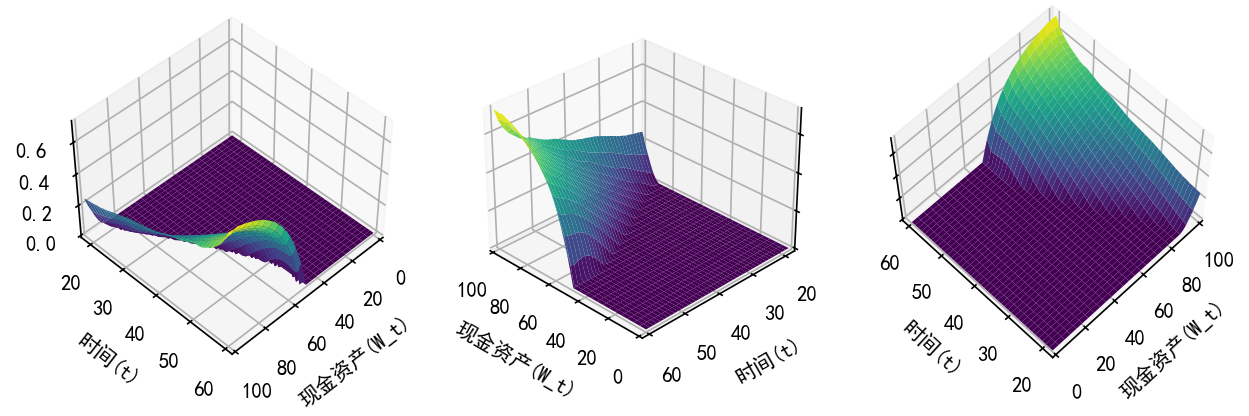

In [ ]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
C = model_results['C'][0,0]  # 消费比例
A = model_results['A'][0,0]  # 风险资产购买比例
Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
V = model_results['V'][0,0]  # 值函数
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 根据Q的形状定义刻度
# 假设Q的形状为(现金W_t, 养老基金余额F_t, 时间t)
gcash = np.linspace(0, 100, Q.shape[0])  # 现金W_t的范围
gfund = np.linspace(0, 50, Q.shape[1])   # 养老基金余额F_t的范围
time_range = np.linspace(tb, td, Q.shape[2])

# 找到tr对应的时间索引
tr_idx = np.abs(time_range - tr).argmin()
# print(f"退休时间点tr = {tr}，对应的索引为{tr_idx}，总时间步数为{Q.shape[2]}")

# 创建网格，但只使用t<tr的部分
time_range_before_tr = time_range[:tr_idx]
W_t, t_mesh = np.meshgrid(gcash, time_range_before_tr)

# 选取特定的F_t值对应的索引
F_t_value = 20  # 选择一个特定的F_t值进行展示
F_t_idx = np.abs(gfund - F_t_value).argmin()
# print(f"选择F_t = {F_t_value}进行展示，对应的索引为{F_t_idx}")

# 绘制Q策略函数的三个从不同角度展示的子图
def plot_Q_strategy_subplots():
    # 创建一个大图，包含3个子图
    fig = plt.figure(figsize=(10, 5), dpi=150)
    # 移除总标题
    # fig.suptitle(f'养老金购买决策策略函数(Q) - F_t = {F_t_value}', fontsize=20, y=0.98)
    
    # 创建颜色映射
    vmin = np.min(Q[:, F_t_idx, :tr_idx])
    vmax = np.max(Q[:, F_t_idx, :tr_idx])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    # 获取对应F_t值的Q数据，并转置以匹配网格
    Q_slice = Q[:, F_t_idx, :tr_idx].T
    
    # 从三个不同角度展示同一个数据
    views = [ (45, 45), (30, 135),(60, 225)]  # (仰角, 方位角)
    # titles = ['视角1 - 侧面', '视角2 - 正面', '视角3 - 背面']
    
    for i, view in enumerate(views):
        # 计算子图位置 (1行3列)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # 绘制3D表面
        surf = ax.plot_surface(W_t, t_mesh, Q_slice, 
                              cmap='viridis', norm=norm, 
                              linewidth=0, antialiased=True)
        
        # 设置坐标轴标签
        ax.set_xlabel('现金资产(W_t)', fontsize=10)
        ax.set_ylabel('时间(t)', fontsize=10)
        
        # z轴刻度只在第一个子图显示
        if i > 0:
            ax.set_zticklabels([])  # 隐藏z轴刻度标签
        # else:
        #     # 只在第一个子图设置z轴标签
        #     ax.set_zlabel('决策值(Q)', fontsize=10)
        
        # 移除子图标题
        # ax.set_title(title, fontsize=13)
        
        # 调整视角
        ax.view_init(view[0], view[1])
        
        # 设置刻度范围
        ax.set_xlim(0, gcash[-1])
        ax.set_ylim(tb, tr)
    
    # 移除共享的颜色条
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 调整颜色条位置
    # cbar = fig.colorbar(surf, cax=cbar_ax)
    # cbar.set_label('养老金购买决策(Q)', fontsize=12)
    
    # 调整布局，确保图像美观
    plt.tight_layout()  # 不需要为颜色条留出空间
    
    # 保存图像
    fig_path = figs_dir / 'p1_Q_strategy_F_20.png'
    plt.savefig(fig_path, bbox_inches='tight',dpi=500)
    plt.show()
    plt.close(fig)
    # print(f"已保存Q策略函数图像到：{fig_path}")

# 运行绘图函数
plot_Q_strategy_subplots()

# print("Q策略函数图像已成功生成并保存到figs目录")


### 图：策略函数Q_t在不同年龄

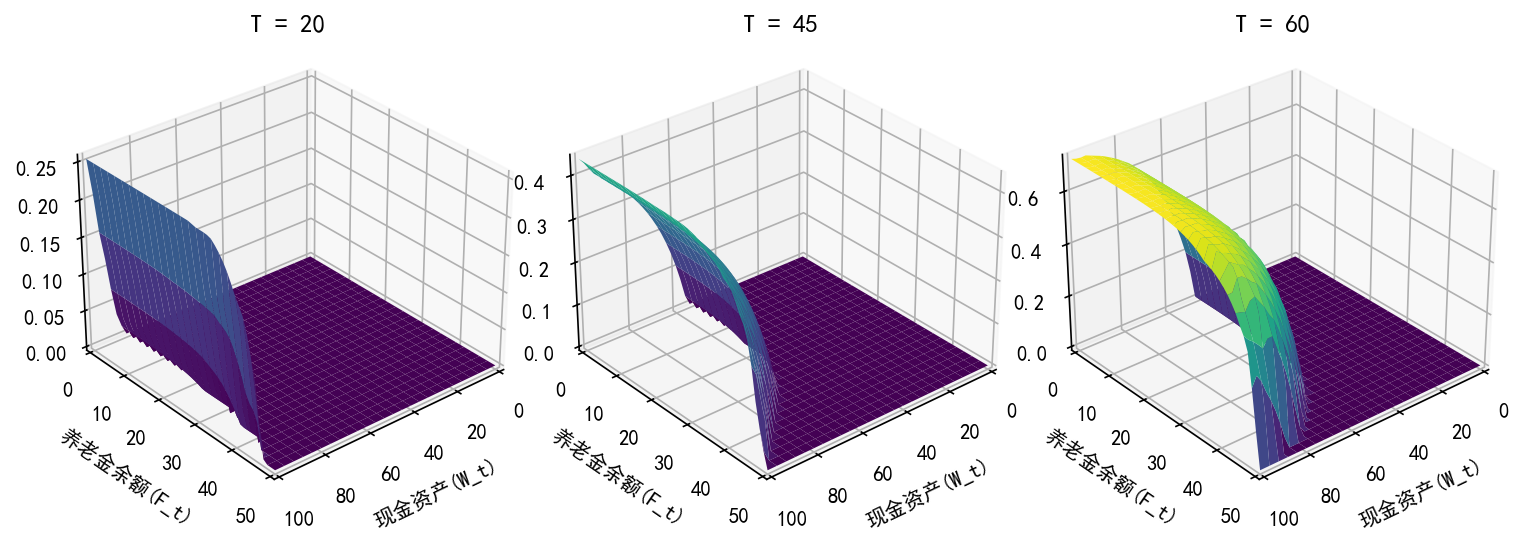

In [3]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
Q = model_results['Q'][0,0]  # 消费比例
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 定义刻度
gcash = np.linspace(0, 100, Q.shape[0])  # 现金W_t的范围
gfund = np.linspace(0, 50, Q.shape[1])   # 养老基金余额F_t的范围
time_range = np.linspace(tb, td, Q.shape[2])

# 绘制不同时间点t的策略函数A(W_t, F_t)的三维图像
def plot_Q_strategy_at_different_times():
    # 选择三个不同的时间点：t=tb, t=40, t=55
    selected_times = [20, 45, 60]
    
    # 查找选择的时间点在time_range中的索引
    time_indices = [np.abs(time_range - t).argmin() for t in selected_times]
    
    # 创建网格
    W_t, F_t = np.meshgrid(gcash, gfund)
    
    # 创建一个大图，包含3个子图
    fig = plt.figure(figsize=(10, 5), dpi=150)
    
    # 创建颜色映射，确保三个子图共享同一个色标范围
    vmin = np.min(Q[:, :, time_indices])
    vmax = np.max(Q[:, :, time_indices])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    
    
    for i, (t, t_idx) in enumerate(zip(selected_times, time_indices)):
        # 计算子图位置 (1行3列)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # 获取t时刻的A数据
        Q_slice = Q[:, :, t_idx].T
        
        # 绘制3D表面
        surf = ax.plot_surface(W_t, F_t, Q_slice, 
                              cmap='viridis', norm=norm, 
                              linewidth=0, antialiased=True)
        
        # 设置坐标轴标签
        ax.set_xlabel('现金资产(W_t)', fontsize=10)
        ax.set_ylabel('养老金余额(F_t)', fontsize=10)
        
        # z轴刻度只在第一个子图显示
        # if i > 0:
        #     ax.set_zticklabels([])  # 隐藏z轴刻度标签
 
        
        # 调整视角
        ax.view_init(30, 50)
        
        # 设置刻度范围
        ax.set_xlim(0, gcash[-1])
        ax.set_ylim(0, gfund[-1])
        # 设置时间点标题，使标题更靠近图
        ax.set_title(f'T = {t}', fontsize=12, pad=1)  # 减小pad值使标题更靠近图形
    
    # 调整布局，确保图像美观
    plt.tight_layout()
    
    # 保存图像
    fig_path = figs_dir / 'p1A_Q_F_and_W_strategy_at_different_times.png'
    plt.savefig(fig_path, bbox_inches='tight',dpi=500)
    plt.show()
    plt.close(fig)

# 运行绘图函数
plot_Q_strategy_at_different_times()

# print("C策略函数图像已成功生成并保存到figs目录")


### 图：策略函数C_t(F_t=20)

C:\Users\qianp\AppData\Local\Temp\ipykernel_3856\2561714486.py:128: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


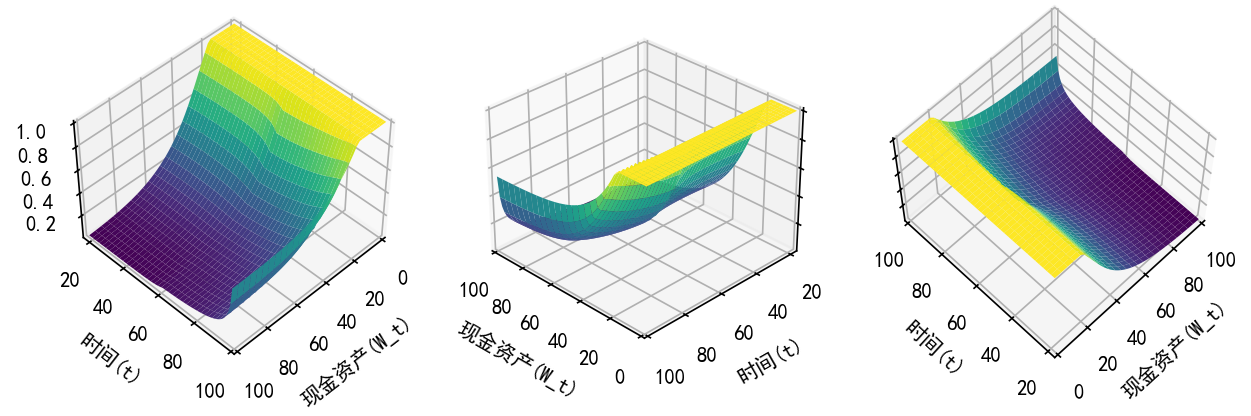

In [2]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
C = model_results['C'][0,0]  # 消费比例
A = model_results['A'][0,0]  # 风险资产购买比例
Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
V = model_results['V'][0,0]  # 值函数
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 根据Q的形状定义刻度
# 假设Q的形状为(现金W_t, 养老基金余额F_t, 时间t)
gcash = np.linspace(0, 100, Q.shape[0])  # 现金W_t的范围
gfund = np.linspace(0, 50, Q.shape[1])   # 养老基金余额F_t的范围
time_range = np.linspace(tb, td, Q.shape[2])

# 找到tr对应的时间索引
tr_idx = np.abs(time_range - td).argmin()
# print(f"退休时间点tr = {tr}，对应的索引为{tr_idx}，总时间步数为{Q.shape[2]}")

# 创建网格，但只使用t<tr的部分
time_range_before_tr = time_range[:tr_idx]
W_t, t_mesh = np.meshgrid(gcash, time_range_before_tr)

# 选取特定的F_t值对应的索引
F_t_value = 20  # 选择一个特定的F_t值进行展示
F_t_idx = np.abs(gfund - F_t_value).argmin()
# print(f"选择F_t = {F_t_value}进行展示，对应的索引为{F_t_idx}")

# 绘制C策略函数的三个从不同角度展示的子图
def plot_C_strategy_subplots():
    # 创建一个大图，包含3个子图
    fig = plt.figure(figsize=(10, 5), dpi=150)
    
    # 创建颜色映射
    vmin = np.min(C[:, F_t_idx, :tr_idx])
    vmax = np.max(C[:, F_t_idx, :tr_idx])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    # 获取对应F_t值的C数据，并转置以匹配网格
    C_slice = C[:, F_t_idx, :tr_idx].T
    
    # 从三个不同角度展示同一个数据
    views = [(45, 45),(30, 135),  (60, 225)]  # (仰角, 方位角)
    
    for i, view in enumerate(views):
        # 计算子图位置 (1行3列)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # 绘制3D表面
        surf = ax.plot_surface(W_t, t_mesh, C_slice, 
                              cmap='viridis', norm=norm, 
                              linewidth=0, antialiased=True)
        
        # 设置坐标轴标签
        ax.set_xlabel('现金资产(W_t)', fontsize=10)
        ax.set_ylabel('时间(t)', fontsize=10)
        
        # z轴刻度只在第一个子图显示
        if i > 0:
            ax.set_zticklabels([])  # 隐藏z轴刻度标签
        # else:
        #     # 只在第一个子图设置z轴标签
        #     ax.set_zlabel('消费比例(C)', fontsize=10)
        
        # a调整视角
        ax.view_init(view[0], view[1])
        
        # 设置刻度范围
        ax.set_xlim(0, gcash[-1])
        ax.set_ylim(tb, td)
    
    # 调整布局，确保图像美观
    plt.tight_layout()
    
    # 保存图像
    fig_path = figs_dir / 'p2_C_strategy_F_20.png'
    plt.savefig(fig_path, bbox_inches='tight',dpi=500)
    plt.show()
    plt.close(fig)

# 运行绘图函数
plot_C_strategy_subplots()

# print("C策略函数图像已成功生成并保存到figs目录")


### 图：策略函数A_t(F_t=20)

C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\2047610854.py:130: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


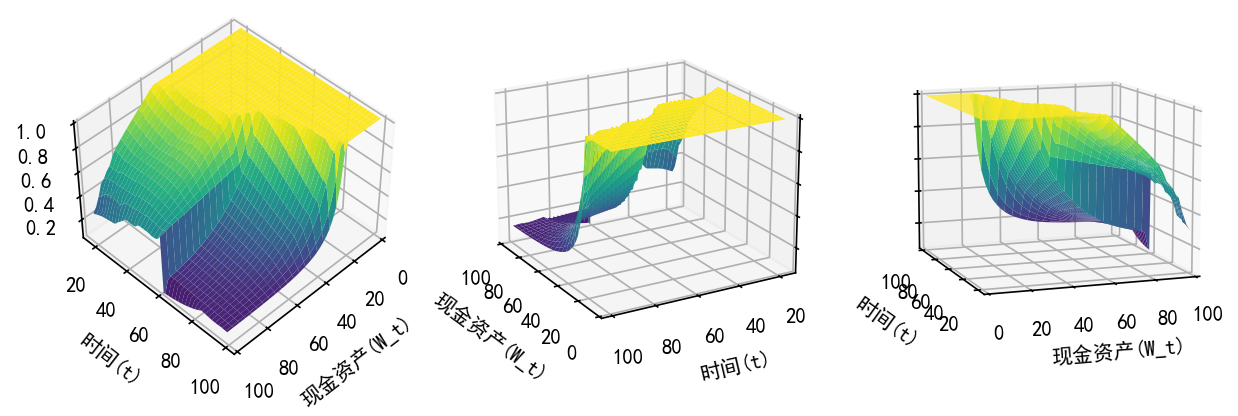

In [5]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
C = model_results['C'][0,0]  # 消费比例
A = model_results['A'][0,0]  # 风险资产购买比例
Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
V = model_results['V'][0,0]  # 值函数
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 根据Q的形状定义刻度
# 假设Q的形状为(现金W_t, 养老基金余额F_t, 时间t)
gcash = np.linspace(0, 100, Q.shape[0])  # 现金W_t的范围
gfund = np.linspace(0, 50, Q.shape[1])   # 养老基金余额F_t的范围
time_range = np.linspace(tb, td, Q.shape[2])

# 找到tr对应的时间索引
tr_idx = np.abs(time_range - td).argmin()
# print(f"退休时间点tr = {tr}，对应的索引为{tr_idx}，总时间步数为{Q.shape[2]}")

# 创建网格，但只使用t<tr的部分
time_range_before_tr = time_range[:tr_idx]
W_t, t_mesh = np.meshgrid(gcash, time_range_before_tr)

# 选取特定的F_t值对应的索引
F_t_value = 20  # 选择一个特定的F_t值进行展示
F_t_idx = np.abs(gfund - F_t_value).argmin()
# print(f"选择F_t = {F_t_value}进行展示，对应的索引为{F_t_idx}")



# 绘制A策略函数的三个从不同角度展示的子图
def plot_A_strategy_subplots():
    # 创建一个大图，包含3个子图
    fig = plt.figure(figsize=(10, 5), dpi=150)
    
    # 创建颜色映射
    vmin = np.min(A[:, F_t_idx, :tr_idx])
    vmax = np.max(A[:, F_t_idx, :tr_idx])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    # 获取对应F_t值的A数据，并转置以匹配网格
    A_slice = A[:, F_t_idx, :tr_idx].T
    
    # 从三个不同角度展示同一个数据
    views = [ (45, 45),(20, 150), (10, 250)]  # (仰角, 方位角)
    
    for i, view in enumerate(views):
        # 计算子图位置 (1行3列)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # 绘制3D表面
        surf = ax.plot_surface(W_t, t_mesh, A_slice, 
                              cmap='viridis', norm=norm, 
                              linewidth=0, antialiased=True)
        
        # 设置坐标轴标签
        ax.set_xlabel('现金资产(W_t)', fontsize=10)
        ax.set_ylabel('时间(t)', fontsize=10)
        
        # z轴刻度只在第一个子图显示
        if i > 0:
            ax.set_zticklabels([])  # 隐藏z轴刻度标签
        # else:
        #     # 只在第一个子图设置z轴标签
        #     ax.set_zlabel('风险资产比例(A)', fontsize=10)
        
        # 调整视角
        ax.view_init(view[0], view[1])
        
        # 设置刻度范围
        ax.set_xlim(0, gcash[-1])
        # ax.set_ylim(tb, tr)
    
    # 调整布局，确保图像美观
    plt.tight_layout()
    
    # 保存图像
    fig_path = figs_dir / 'p3_A_strategy_F_20.png'
    plt.savefig(fig_path, bbox_inches='tight',dpi=500)
    plt.show()
    plt.close(fig)

# 运行绘图函数
# plot_C_strategy_subplots()
plot_A_strategy_subplots()

# print("C策略函数图像已成功生成并保存到figs目录")


### 图：策略函数A_t在不同年龄

C:\Users\qianp\AppData\Local\Temp\ipykernel_42772\3104611087.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


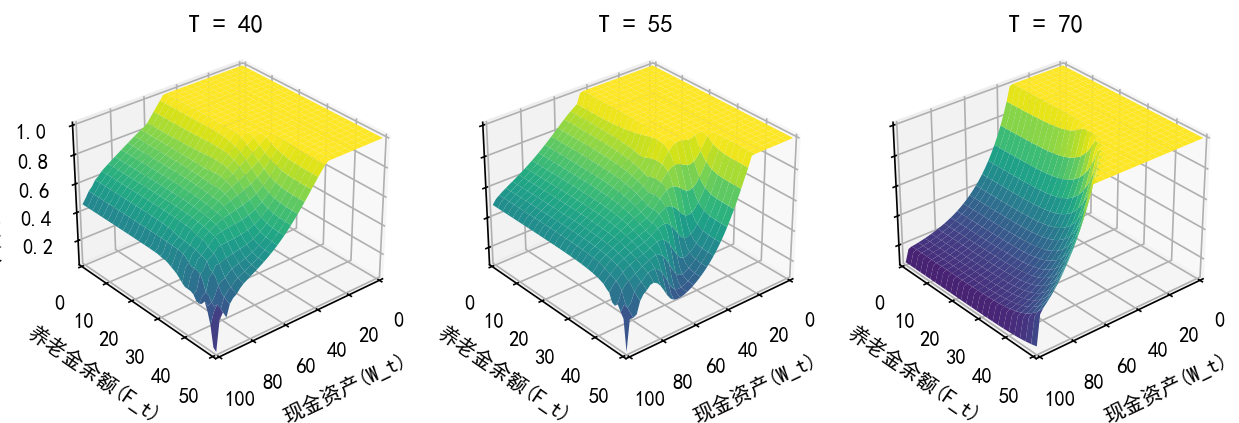

In [19]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
C = model_results['C'][0,0]  # 消费比例
A = model_results['A'][0,0]  # 风险资产购买比例
Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
V = model_results['V'][0,0]  # 值函数
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 定义刻度
gcash = np.linspace(0, 100, Q.shape[0])  # 现金W_t的范围
gfund = np.linspace(0, 50, Q.shape[1])   # 养老基金余额F_t的范围
time_range = np.linspace(tb, td, Q.shape[2])

# 绘制不同时间点t的策略函数A(W_t, F_t)的三维图像
def plot_A_strategy_at_different_times():
    # 选择三个不同的时间点：t=tb, t=40, t=55
    selected_times = [40, 55, 70]
    
    # 查找选择的时间点在time_range中的索引
    time_indices = [np.abs(time_range - t).argmin() for t in selected_times]
    
    # 创建网格
    W_t, F_t = np.meshgrid(gcash, gfund)
    
    # 创建一个大图，包含3个子图
    fig = plt.figure(figsize=(10, 5), dpi=150)
    
    # 创建颜色映射，确保三个子图共享同一个色标范围
    vmin = np.min(A[:, :, time_indices])
    vmax = np.max(A[:, :, time_indices])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    
    
    for i, (t, t_idx) in enumerate(zip(selected_times, time_indices)):
        # 计算子图位置 (1行3列)
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        # 获取t时刻的A数据
        A_slice = A[:, :, t_idx].T
        
        # 绘制3D表面
        surf = ax.plot_surface(W_t, F_t, A_slice, 
                              cmap='viridis', norm=norm, 
                              linewidth=0, antialiased=True)
        
        # 设置坐标轴标签
        ax.set_xlabel('现金资产(W_t)', fontsize=10)
        ax.set_ylabel('养老金余额(F_t)', fontsize=10)
        
        # z轴刻度只在第一个子图显示
        if i > 0:
            ax.set_zticklabels([])  # 隐藏z轴刻度标签
        else:
            ax.set_zlabel('风险资产比例(A)', fontsize=10)
        
        # 调整视角
        ax.view_init(30, 50)
        
        # 设置刻度范围
        ax.set_xlim(0, gcash[-1])
        ax.set_ylim(0, gfund[-1])
        # 设置时间点标题，使标题更靠近图
        ax.set_title(f'T = {t}', fontsize=12, pad=1)  # 减小pad值使标题更靠近图形
    
    # 调整布局，确保图像美观
    plt.tight_layout()
    
    # 保存图像
    fig_path = figs_dir / 'p4_A_F_and_W_strategy_at_different_times.png'
    plt.savefig(fig_path, bbox_inches='tight',dpi=500)
    plt.show()
    plt.close(fig)

# 运行绘图函数
plot_A_strategy_at_different_times()

# print("C策略函数图像已成功生成并保存到figs目录")


### 图：数值模拟基本结果

数值模拟开始...
生成劳动收入模拟数据...


C:\Users\qianp\AppData\Local\Temp\ipykernel_26684\2240210433.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
C:\Users\qianp\AppData\Local\Temp\ipykernel_26684\2240210433.py:157: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])


生成风险投资收益率模拟数据...
模拟控制变量...


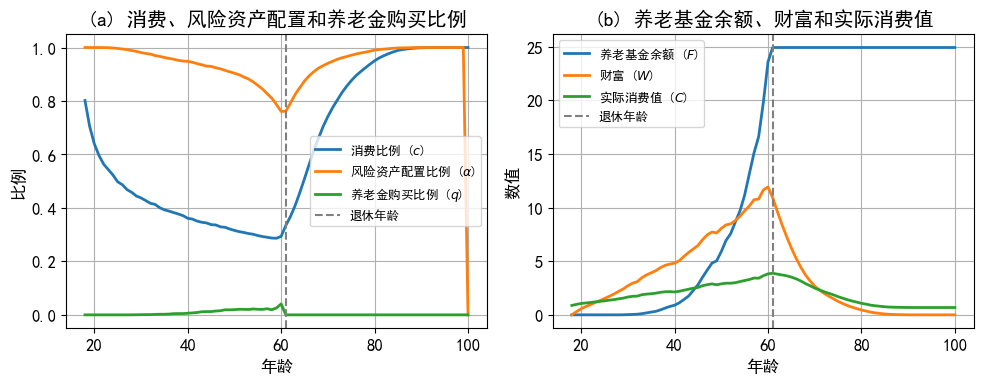

数值模拟完成，结果已保存到result_baseline_matlab_PFI/simulation文件夹
合并图表已保存到d:\OneDrive - 北京大学\工作台\博士论文\程序\1_养老金基准\figs\p5_simu_basics.png


In [13]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp2d, griddata, RegularGridInterpolator

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()
mat_file_path = current_dir / 'result_baseline_matlab_PFI' / 'model_results.mat'

# 首先打印文件路径，确认路径是否正确
# print(f"尝试读取文件：{mat_file_path}")
# print(f"文件是否存在：{mat_file_path.exists()}")

# try:
# 使用scipy.io替代h5py来读取.mat文件
mat_contents = sio.loadmat(str(mat_file_path))

# 获取model_results结构体中的数据
model_results = mat_contents['model_results']

# 读取各个数组
# 对于MATLAB结构体，需要使用特殊的索引方式
C = model_results['C'][0,0]  # 消费比例
A = model_results['A'][0,0]  # 风险资产购买比例
Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
V = model_results['V'][0,0]  # 值函数
tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

# 提取更多参数
rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
pension_pct = model_results['params'][0,0]['pension_pct'][0,0][0,0]  # 工资扣除缴纳养老保险的比例
pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
gcash = model_results['gcash'][0,0]  # 现金W_t的范围
gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围

# print("\n数据形状：")
# print(f"C shape: {C.shape}")
# print(f"A shape: {A.shape}")
# print(f"Q shape: {Q.shape}")
# print(f"V shape: {V.shape}")

# except Exception as e:
#     print(f"读取文件时出错：{str(e)}")
    
#     # 如果上述方法失败，我们可以尝试使用h5py
#     try:
#         import h5py
#         with h5py.File(str(mat_file_path), 'r') as f:
#             print("\n文件中的键：")
#             print(list(f.keys()))
#     except Exception as e2:
#         print(f"\n使用h5py也失败：{str(e2)}")

# 创建保存图像的目录
figs_dir = current_dir / 'figs'
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)
    print(f"创建目录：{figs_dir}")

# 定义刻度

time_range = np.linspace(tb, td, C.shape[2])

# print("C策略函数图像已成功生成并保存到figs目录")

# 数值模拟函数
def simulate_model():
    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        
        # 存储策略
        simC[t, :] = simC_t
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额
            if t < (tr-tb):  # 工作期 - 养老基金增长
                simF[t+1, :] = (simF[t, :] + pension_purchase) * rp / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少，但至少保留原值（根据MATLAB代码的行为）
                simF[t+1, :] = simF[t, :]
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    figs_dir = current_dir / 'figs'
    if not os.path.exists(sim_dir):
        os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)
    
    # 保存原始模拟数据
    np.savez(sim_dir / 'raw_simulation.npz',
             simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
             simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)
    
    # 绘图部分 - 将两张图合并为1x2布局
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # 第一个子图：决策变量图
    axes[0].plot(np.arange(tb, td+1), meanC_pct, linewidth=2, label='消费比例 ($c$)')
    axes[0].plot(np.arange(tb, td+1), meanalpha, linewidth=2, label='风险资产配置比例 ($\\alpha$)')
    axes[0].plot(np.arange(tb, td+1), meanQ, linewidth=2, label='养老金购买比例 ($q$)')
    axes[0].axvline(x=tr, linestyle='--', color='gray', linewidth=1.5, label='退休年龄')
    axes[0].legend(loc='best',fontsize=9)
    axes[0].set_xlabel('年龄')
    axes[0].set_ylabel('比例')
    axes[0].set_title('(a) 消费、风险资产配置和养老金购买比例')
    axes[0].grid(True)
    
    # 第二个子图：养老基金余额、财富和实际消费值
    axes[1].plot(np.arange(tb, td+1), meanF, linewidth=2, label='养老基金余额 ($F$)')
    axes[1].plot(np.arange(tb, td+1), meanW, linewidth=2, label='财富 ($W$)')
    axes[1].plot(np.arange(tb, td+1), meanRealC, linewidth=2, label='实际消费值 ($C$)')
    axes[1].axvline(x=tr, linestyle='--', color='gray', linewidth=1.5, label='退休年龄')
    axes[1].legend(loc='best',fontsize=9)
    axes[1].set_xlabel('年龄')
    axes[1].set_ylabel('数值')
    axes[1].set_title('(b) 养老基金余额、财富和实际消费值')
    axes[1].grid(True)
    
    # 调整子图之间的间距
    plt.tight_layout()
    
    # 保存合并后的图表
    figs_dir = current_dir / 'figs'
    plt.savefig(figs_dir / 'p5_simu_basics.png', dpi=300)
    plt.show()
    plt.close()
    
    print('数值模拟完成，结果已保存到result_baseline_matlab_PFI/simulation文件夹')
    print(f'合并图表已保存到{figs_dir / "p5_simu_basics.png"}')
    
    # 返回模拟结果
    return sim_results

# 运行模拟函数
if __name__ == "__main__":
    sim_results = simulate_model()


### 图：养老金模型与Cocco模型比较

数值模拟开始...


C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\481991434.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\481991434.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])


数值模拟开始...


C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\481991434.py:339: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\481991434.py:340: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])


数值模拟开始...


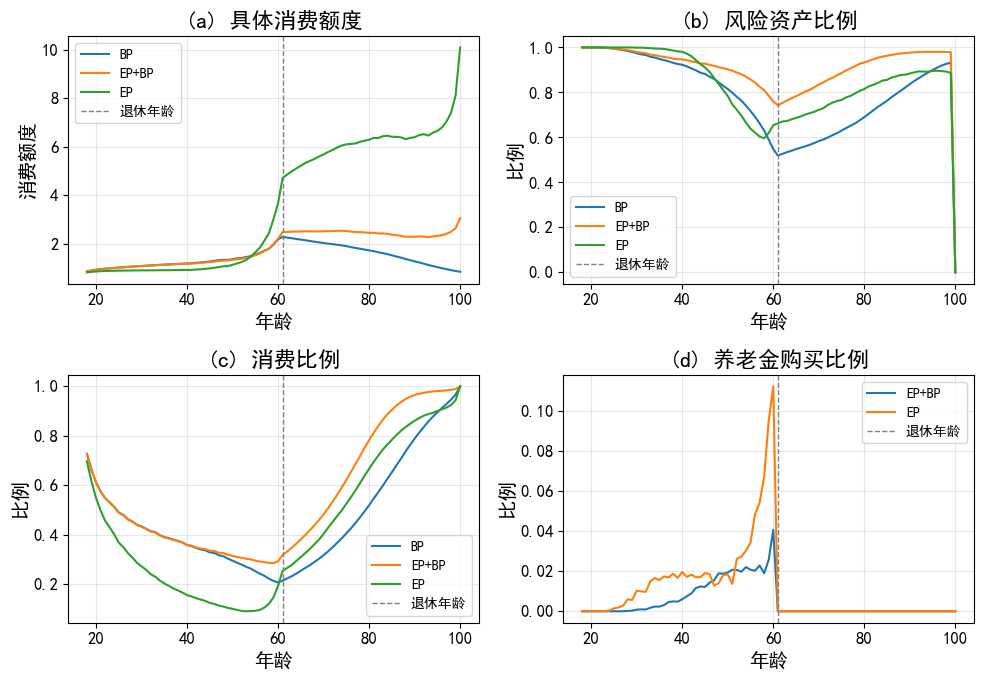

三个模型的比较图表已保存到 e:\OneDrive - pku.edu.cn\工作台\博士论文\程序\1_养老金基准\figs\p6_model_comparison.png


In [26]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp2d, griddata, RegularGridInterpolator

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 12  # 增加默认字体大小
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()

def simulate_model_cocco(mat_file_path):
# 首先打印文件路径，确认路径是否正确
    # print(f"尝试读取文件：{mat_file_path}")
    # print(f"文件是否存在：{mat_file_path.exists()}")

    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围

    # 定义刻度


    # print("C策略函数图像已成功生成并保存到figs目录")

# 数值模拟函数

    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)

    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0.2  # 初始财富设置为0
    
    # 创建网格点
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,t].ravel()  # 展平为一维数组
        A_t = A[:,t].ravel()
        

        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(gcash, C_t, cash_t, method='cubic')
        simA_t = griddata(gcash, A_t, cash_t, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        
        # 存储策略 
        simC[t, :] = simC_t * cash[t, :] # 具体消费额
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 剩余投资
        remaining_sav = sav  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })

    return sim_results    

def simulate_model_baseline(mat_file_path):


    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围
    gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围


    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0.2  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        if t < (tr-tb):  # 工作期
            cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        else:
            cash[t, :] = simW[t, :] + simY[t, :] + simF[t, :] * pension_rate       

        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        
        # 存储策略
        simC[t, :] = simC_t * cash[t, :]
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额
            if t < (tr-tb):  # 工作期 - 养老基金增长
                simF[t+1, :] = (simF[t, :] + pension_purchase) * rp / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少，但至少保留原值（根据MATLAB代码的行为）
                simF[t+1, :] = simF[t, :]
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    # sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    # figs_dir = current_dir / 'figs'
    # if not os.path.exists(sim_dir):
    #     os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    # sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)

    return sim_results
    # 保存原始模拟数据
    # np.savez(sim_dir / 'raw_simulation.npz',
    #          simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
    #          simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)
    
    
    


# 运行模拟函数
if __name__ == "__main__":

    mat_file_path = current_dir / 'result' / 'cocco.mat'
    cocco_sim_results = simulate_model_cocco(mat_file_path)

    mat_file_path = current_dir / 'result' / 'baseline.mat'
    baseline_sim_results = simulate_model_baseline(mat_file_path)

    mat_file_path = current_dir / 'result' / 'baseline_no_ret_fac.mat'
    baseline_no_ret_fac_sim_results = simulate_model_baseline(mat_file_path)  

    # 获取时间参数 (使用baseline_sim_results的时间参数作为基准)
    tb = 18
    td = 100
    tr = 61
    age_range = np.arange(tb, td+1)

    # 创建保存图像的目录
    figs_dir = current_dir / 'figs'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

    # 绘制比较图 - 2x2布局而非1x4布局
    fig, axes = plt.subplots(2,2, figsize=(10, 8))  # 增加图表尺寸
       
    # 第一个子图：比较三个模型的具体消费额度(meanC)
    axes[0,0].plot(age_range, cocco_sim_results['meanC'], linewidth=1.5)
    axes[0,0].plot(age_range, baseline_sim_results['meanC'], linewidth=1.5)
    axes[0,0].plot(age_range, baseline_no_ret_fac_sim_results['meanC'], linewidth=1.5)
    axes[0,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,0].set_xlabel('年龄', fontsize=14)
    axes[0,0].set_ylabel('消费额度', fontsize=14)
    axes[0,0].set_title('(a) 具体消费额度', fontsize=16)
    axes[0,0].tick_params(axis='both', which='major', labelsize=12)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend(['BP', 'EP+BP', 'EP', '退休年龄'], 
        loc='upper left', ncol=1, fontsize=10)   

    
    # 第二个子图：比较三个模型的风险资产比例(meanalpha)
    axes[0,1].plot(age_range, cocco_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].plot(age_range, baseline_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].plot(age_range, baseline_no_ret_fac_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,1].set_xlabel('年龄', fontsize=14)
    axes[0,1].set_ylabel('比例', fontsize=14)
    axes[0,1].set_title('(b) 风险资产比例', fontsize=16)
    axes[0,1].tick_params(axis='both', which='major', labelsize=12)
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend(['BP', 'EP+BP', 'EP', '退休年龄'], 
        loc='lower left', ncol=1, fontsize=10)   

    # 第三个子图：比较三个模型的消费比例(meanC_pct)
    axes[1,0].plot(age_range, cocco_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].plot(age_range, baseline_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].plot(age_range, baseline_no_ret_fac_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[1,0].set_xlabel('年龄', fontsize=14)
    axes[1,0].set_ylabel('比例', fontsize=14)
    axes[1,0].set_title('(c) 消费比例', fontsize=16)
    axes[1,0].tick_params(axis='both', which='major', labelsize=12)
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend(['BP', 'EP+BP', 'EP', '退休年龄'], 
        loc='lower right', ncol=1, fontsize=10)   
    
    # 第四个子图：比较后两个模型的个人养老金决策比例(meanQ)
    l1 = axes[1,1].plot(age_range, baseline_sim_results['meanQ'], linewidth=1.5, label='EP+BP')
    l2 = axes[1,1].plot(age_range, baseline_no_ret_fac_sim_results['meanQ'], linewidth=1.5, label='EP')
    l3 = axes[1,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1, label='退休年龄')
    axes[1,1].set_xlabel('年龄', fontsize=14)
    axes[1,1].set_ylabel('比例', fontsize=14)
    axes[1,1].set_title('(d) 养老金购买比例', fontsize=16)
    axes[1,1].tick_params(axis='both', which='major', labelsize=12)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend([ 'EP+BP', 'EP', '退休年龄'], 
        loc='upper right', ncol=1, fontsize=10) 
    
        # 第5个子图：比较三个模型的财富(meanW)
    # axes[2,0].plot(age_range, cocco_sim_results['meanW'], linewidth=1.5)
    # axes[2,0].plot(age_range, baseline_sim_results['meanW'], linewidth=1.5)
    # axes[2,0].plot(age_range, baseline_no_ret_fac_sim_results['meanW'], linewidth=1.5)
    # axes[2,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    # axes[2,0].set_xlabel('年龄', fontsize=14)
    # axes[2,0].set_ylabel('比例', fontsize=14)
    # axes[2,0].set_title('(e) 财富', fontsize=16)
    # axes[2,0].tick_params(axis='both', which='major', labelsize=12)
    # axes[2,0].grid(True, alpha=0.3)
    # axes[2,0].legend(['BP', 'EP+BP', 'EP', '退休年龄'], 
    #     loc='lower right', ncol=1, fontsize=10)   
    
    
    # 只在最后一个子图添加legend
    # 添加前三个子图的图例项
    # l0 = axes[1,1].plot([], [], linewidth=1.5, label='Cocco模型')[0]


    
    # 调整子图之间的间距和整体布局
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # 保存图片
    plt.savefig(figs_dir / 'p6_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f'三个模型的比较图表已保存到 {figs_dir / "p6_model_comparison.png"}')

### 图：敏感性分析-参数

参数字段列表:


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\2616026143.py:125: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
C:\Users\qianp\AppData\Local\Temp\ipykernel_35508\2616026143.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])


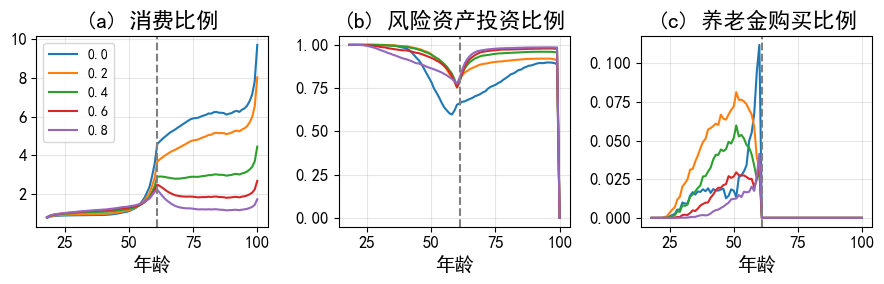

100%|██████████| 1/1 [00:29<00:00, 29.02s/it]


In [25]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp2d, griddata, RegularGridInterpolator
import glob
from tqdm import tqdm

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 12  # 增加默认字体大小
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()

def simulate_model_baseline(model_results):


    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    # mat_contents = sio.loadmat(str(mat_file_path))

    # # 获取model_results结构体中的数据
    # model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围
    gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围


    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    # print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        # cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        if t < (tr-tb):  # 工作期
            cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        else:
            cash[t, :] = simW[t, :] + fund[t, :] * pension_rate
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        
        # 存储策略
        simC[t, :] = simC_t * cash[t, :]
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                # print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额
            if t < (tr-tb):  # 工作期 - 养老基金增长
                simF[t+1, :] = (simF[t, :] + pension_purchase) * rp / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少，但至少保留原值（根据MATLAB代码的行为）
                simF[t+1, :] = simF[t, :]
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    # sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    # figs_dir = current_dir / 'figs'
    # if not os.path.exists(sim_dir):
    #     os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    # sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)

    return sim_results
    # 保存原始模拟数据
    # np.savez(sim_dir / 'raw_simulation.npz',
    #          simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
    #          simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)


if __name__ == "__main__":

    # 设置结果保存目录
    save_dir = 'figs'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 设置数据源目录
    data_dir = 'result/sensitivity'
    if not os.path.exists(data_dir):
        raise Exception(f'数据目录不存在: {data_dir}')

    # 获取参数值列表（从sensitivity_analysis.py中提取）
    params = {
    'basic_pension_ret_fac': [0, 0.2, 0.4, 0.6, 0.8],
}
        
    # params = {
    #     'retirement_age_tr': [61, 62, 63, 64, 65],
    #     'basic_pension_ret_fac': [0, 0.2, 0.4, 0.6, 0.8],
    #     'pension_return_rp': [1.00, 1.02, 1.04, 1.06, 1.08],
    #     'risk_aversion_gamma': [2.0, 3.0, 4.0, 5.0, 7.0],
    #     'time_preference_beta': [0.92, 0.94, 0.95, 0.96, 0.98],
    #     'risk_volatility_sigr': [0.15, 0.20, 0.27, 0.35, 0.45],
    #     'smav': [np.sqrt(0), np.sqrt(0.2), np.sqrt(0.4), np.sqrt(0.5), np.sqrt(0.8)],
    #     'smay': [np.sqrt(0), np.sqrt(0.2), np.sqrt(0.4), np.sqrt(0.5), np.sqrt(0.8)],
    #     'corr_z_epsilon': [0.1, 0.2, 0.5, 0.8]
    # }

    # 参数字段的中文名称映射
    param_names_cn = {
        'retirement_age_tr': '退休年龄',
        'basic_pension_ret_fac': '基础养老金替代率', 
        'pension_return_rp': '养老基金收益率',
        'risk_aversion_gamma': '风险厌恶系数',
        'time_preference_beta': '时间偏好系数',
        'risk_volatility_sigr': '风险资产波动率',
        'smav': '永久性收入冲击标准差',
        'smay': '暂时性收入冲击标准差',
        'corr_z_epsilon': '收入冲击相关系数'
    }

    # 获取参数字段名称
    param_fields = list(params.keys())

    # 打印所有参数字段
    print('参数字段列表:')
    idx = 7
    for param_name in tqdm(param_fields):
        # 获取所有以param_name开头的文件
        data_files = glob.glob(os.path.join(data_dir, f'{param_name}_*.mat'))
        
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # 增加图表尺寸
        plt.subplots_adjust(top=0.865,
                           bottom=0.199,
                           left=0.048,
                           right=0.983,
                           hspace=0.2,
                           wspace=0.237)
        param_list = []
        # 遍历当前参数的所有数据文件
        for data_file in data_files:
            # 加载数据
            data = sio.loadmat(data_file)
            model_results = data['model_results']
            # 获取参数值
            param_value = data_file.split('_')[-1].replace('.mat', '')
            param_list.append(param_value)
            tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
            td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
            tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点
            
            # 进行模拟并获取结果
            simu_results = simulate_model_baseline(model_results)
            
            # 将结果添加到图表中
            axes[0].plot(np.arange(tb, td+1), simu_results.meanC)
            
            axes[1].plot(np.arange(tb, td+1), simu_results.meanalpha)
            
            axes[2].plot(np.arange(tb, td+1), simu_results.meanQ)
 

        axes[0].legend(param_list,fontsize=10)
        axes[0].set_title('(a) 消费比例', fontsize=16)
        axes[1].set_title('(b) 风险资产投资比例', fontsize=16)
        axes[2].set_title('(c) 养老金购买比例', fontsize=16)
        axes[0].set_xlabel('年龄', fontsize=14)
        axes[1].set_xlabel('年龄', fontsize=14)
        axes[2].set_xlabel('年龄', fontsize=14)
        axes[0].grid(True, alpha=0.3)
        axes[1].grid(True, alpha=0.3)
        axes[2].grid(True, alpha=0.3)

        axes[0].axvline(x=tr, linestyle='--', color='gray', linewidth=1.5, label='退休年龄')
        axes[1].axvline(x=tr, linestyle='--', color='gray', linewidth=1.5, label='退休年龄')
        axes[2].axvline(x=tr, linestyle='--', color='gray', linewidth=1.5, label='退休年龄')

        plt.tight_layout()
        plt.show()
        # plt.savefig(os.path.join(save_dir, f'p{idx}_sensitivity_{param_names_cn[param_name]}.png'), dpi=300, bbox_inches='tight')
        idx +=1
        plt.close()

### （x）图：敏感性分析-Epstein-Zin效用函数

In [ ]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp2d, griddata, RegularGridInterpolator

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 12  # 增加默认字体大小
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()

def simulate_model_cocco(mat_file_path):
# 首先打印文件路径，确认路径是否正确
    # print(f"尝试读取文件：{mat_file_path}")
    # print(f"文件是否存在：{mat_file_path.exists()}")

    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围

    # 定义刻度


    # print("C策略函数图像已成功生成并保存到figs目录")

# 数值模拟函数

    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)

    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    
    # 创建网格点
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,t].ravel()  # 展平为一维数组
        A_t = A[:,t].ravel()
        

        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(gcash, C_t, cash_t, method='cubic')
        simA_t = griddata(gcash, A_t, cash_t, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        
        # 存储策略 
        simC[t, :] = simC_t * cash[t, :] # 具体消费额
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 剩余投资
        remaining_sav = sav  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })

    return sim_results    

def simulate_model_baseline(mat_file_path):


    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围
    gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围


    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        
        # 存储策略
        simC[t, :] = simC_t * cash[t, :]
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额
            if t < (tr-tb):  # 工作期 - 养老基金增长
                simF[t+1, :] = (simF[t, :] + pension_purchase) * rp / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少，但至少保留原值（根据MATLAB代码的行为）
                simF[t+1, :] = simF[t, :]
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    # sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    # figs_dir = current_dir / 'figs'
    # if not os.path.exists(sim_dir):
    #     os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    # sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)

    return sim_results
    # 保存原始模拟数据
    # np.savez(sim_dir / 'raw_simulation.npz',
    #          simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
    #          simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)
    
    
    


# 运行模拟函数
if __name__ == "__main__":


    mat_file_path = current_dir / 'result' / 'baseline.mat'
    baseline_sim_results = simulate_model_baseline(mat_file_path)

    mat_file_path = current_dir / 'result' / 'sensitivity' / 'EpsteinZin' / 'model_results.mat'
    baseline_EZ_sim_results = simulate_model_baseline(mat_file_path)  

    # 获取时间参数 (使用baseline_sim_results的时间参数作为基准)
    tb = 18
    td = 100
    tr = 61
    age_range = np.arange(tb, td+1)

    # 创建保存图像的目录
    figs_dir = current_dir / 'figs'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

    # 绘制比较图 - 2x2布局而非1x4布局
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 增加图表尺寸
       
    # 第一个子图：比较三个模型的具体消费额度(meanC)
    axes[0,0].plot(age_range, baseline_EZ_sim_results['meanC'], linewidth=1.5)
    axes[0,0].plot(age_range, baseline_sim_results['meanC'], linewidth=1.5)
    axes[0,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,0].set_xlabel('年龄', fontsize=14)
    axes[0,0].set_ylabel('消费额度', fontsize=14)
    axes[0,0].set_title('(a) 具体消费额度', fontsize=16)
    axes[0,0].tick_params(axis='both', which='major', labelsize=12)
    axes[0,0].grid(True, alpha=0.3)

    
    # 第二个子图：比较三个模型的风险资产比例(meanalpha)
    axes[0,1].plot(age_range, baseline_EZ_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].plot(age_range, baseline_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,1].set_xlabel('年龄', fontsize=14)
    axes[0,1].set_ylabel('比例', fontsize=14)
    axes[0,1].set_title('(b) 风险资产比例', fontsize=16)
    axes[0,1].tick_params(axis='both', which='major', labelsize=12)
    axes[0,1].grid(True, alpha=0.3)


    # 第三个子图：比较三个模型的消费比例(meanC_pct)
    axes[1,0].plot(age_range, baseline_EZ_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].plot(age_range, baseline_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[1,0].set_xlabel('年龄', fontsize=14)
    axes[1,0].set_ylabel('比例', fontsize=14)
    axes[1,0].set_title('(c) 消费比例', fontsize=16)
    axes[1,0].tick_params(axis='both', which='major', labelsize=12)
    axes[1,0].grid(True, alpha=0.3)
    
    # 第四个子图：比较后两个模型的个人养老金决策比例(meanQ)
    l1 = axes[1,1].plot(age_range,baseline_EZ_sim_results['meanQ'], linewidth=1.5, label='Epstein-Zin')
    l2 = axes[1,1].plot(age_range, baseline_sim_results['meanQ'], linewidth=1.5, label='基准模型')
    l3 = axes[1,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1, label='退休年龄')
    axes[1,1].set_xlabel('年龄', fontsize=14)
    axes[1,1].set_ylabel('比例', fontsize=14)
    axes[1,1].set_title('(d) 养老金购买比例', fontsize=16)
    axes[1,1].tick_params(axis='both', which='major', labelsize=12)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend(['Epstein-Zin($\\gamma=3.84,\\psi=0.15$)', 'CRRA($\\gamma=3.84$)', '退休年龄'], 
        loc='upper right', ncol=1, fontsize=10)   

    
    # 只在最后一个子图添加legend
    # 添加前三个子图的图例项
    # l0 = axes[1,1].plot([], [], linewidth=1.5, label='Cocco模型')[0]


    
    # 调整子图之间的间距和整体布局
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # 保存图片
    plt.savefig(figs_dir / 'p16_sensitivity_epsteinzin.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f'三个模型的比较图表已保存到 {figs_dir / "p16_sensitivity_epsteinzin.png"}')

### 图：敏感性分析-RiskyRp(允许养老金投资风险资产)

In [ ]:
import scipy.io as sio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import pandas as pd
from scipy.interpolate import interp2d, griddata, RegularGridInterpolator

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['font.size'] = 12  # 增加默认字体大小
mpl.rcParams['font.family'] = 'SimHei'  # 确保全局字体设置为支持中文的字体

# 获取当前notebook所在目录的路径
current_dir = Path().absolute()

def simulate_model_riskyrp(mat_file_path):


    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
    Q_Alpha = model_results['Q_Alpha'][0,0]  # 养老金风险投资比例 - 新增
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围
    gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围


    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanQ_Alpha = np.zeros(tn)  # 平均养老金风险投资比例 - 新增
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simQ_Alpha = np.zeros((tn, nsim))  # 模拟养老金风险投资比例 - 新增
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        Q_Alpha_t = Q_Alpha[:,:,t].ravel()  # 养老金风险投资比例 - 新增
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        simQ_Alpha_t = griddata(grid_points, Q_Alpha_t, query_points, method='cubic')  # 养老金风险投资比例 - 新增
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        simQ_Alpha_t = np.clip(simQ_Alpha_t, 0, 1)  # 养老金风险投资比例范围约束为0-1 - 新增
        
        # 存储策略
        simC[t, :] = simC_t * cash[t, :]
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        high_consumption_mask = simC_t > 0.9999
        simA_t[high_consumption_mask] = 0
        simQ_t[high_consumption_mask] = 0
        simQ_Alpha_t[high_consumption_mask] = 0  # 养老金风险投资比例也设为0 - 新增
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        simQ_Alpha[t, :] = simQ_Alpha_t  # 养老金风险投资比例 - 新增
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额，考虑养老金风险投资比例 - 修改
            if t < (tr-tb):  # 工作期 - 养老基金增长
                # 计算养老基金的投资回报率
                pension_return = rf * (1 - simQ_Alpha[t, :]) + simR[t, :] * simQ_Alpha[t, :]
                simF[t+1, :] = (simF[t, :] + pension_purchase) * pension_return / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少
                # 退休期养老基金余额的更新（考虑风险投资）
                pension_return = rf * (1 - simQ_Alpha[t, :]) + simR[t, :] * simQ_Alpha[t, :]
                simF[t+1, :] = (simF[t, :] - simP[t, :]) * pension_return
                # simF[t+1, :] = np.maximum(simF[t+1, :], 0)  # 确保养老基金余额非负
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanQ_Alpha = np.mean(simQ_Alpha, axis=1)  # 养老金风险投资比例 - 新增
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    # sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    # figs_dir = current_dir / 'figs'
    # if not os.path.exists(sim_dir):
    #     os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanQ_Alpha': meanQ_Alpha,  # 养老金风险投资比例 - 新增
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    # sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)

    # # 绘制Q、A、C、Q_Alpha四个决策变量在同一个图中
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(tb, td+1), meanC_pct, linewidth=2, label='消费比例 (c)')
    # plt.plot(range(tb, td+1), meanalpha, linewidth=2, label='风险资产配置比例 (α)')
    # plt.plot(range(tb, td+1), meanQ, linewidth=2, label='养老金购买比例 (q)')
    # plt.plot(range(tb, td+1), meanQ_Alpha, linewidth=2, label='养老金风险投资比例 (q_α)')
    # plt.axvline(x=tr, linestyle='--', color='r', linewidth=1.5, label='退休年龄')
    # plt.legend(loc='best')
    # plt.xlabel('年齡')
    # plt.ylabel('比例')
    # plt.title('消费、风险资产配置和养老金相关决策比例')
    # plt.grid(True)
    
    # # 绘制养老基金余额
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(tb, td+1), meanF, linewidth=2, label='养老基金余额 (F)')
    # plt.plot(range(tb, td+1), meanP, linewidth=2, label='养老金给付 (P)')
    # plt.axvline(x=tr, linestyle='--', color='r', linewidth=1.5, label='退休年龄')
    # plt.legend(loc='best')
    # plt.xlabel('期数')
    # plt.ylabel('数值')
    # plt.title('养老基金余额和养老金给付')
    # plt.grid(True)
    
    # # 绘制养老金风险投资比例
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(tb, td+1), meanQ_Alpha, linewidth=2, label='养老金风险投资比例 (q_α)')
    # plt.axvline(x=tr, linestyle='--', color='r', linewidth=1.5, label='退休年龄')
    # plt.legend(loc='best')
    # plt.xlabel('年齡')
    # plt.ylabel('比例')
    # plt.title('养老金风险投资比例')
    # plt.grid(True)

    return sim_results
    # 保存原始模拟数据
    # np.savez(sim_dir / 'raw_simulation.npz',
    #          simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
    #          simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)

def simulate_model_baseline(mat_file_path):


    # try:
    # 使用scipy.io替代h5py来读取.mat文件
    mat_contents = sio.loadmat(str(mat_file_path))

    # 获取model_results结构体中的数据
    model_results = mat_contents['model_results']

    # 读取各个数组
    # 对于MATLAB结构体，需要使用特殊的索引方式
    C = model_results['C'][0,0]  # 消费比例
    A = model_results['A'][0,0]  # 风险资产购买比例
    Q = model_results['Q'][0,0]  # 养老金购买决策策略函数
    V = model_results['V'][0,0]  # 值函数
    tb = model_results['params'][0,0]['tb'][0,0][0,0]  # 时间起点
    td = model_results['params'][0,0]['td'][0,0][0,0]  # 时间终点
    tr = model_results['params'][0,0]['tr'][0,0][0,0]  # 退休时间点

    # 提取更多参数
    rf = model_results['params'][0,0]['rf'][0,0][0,0]  # 无风险收益率
    rp = model_results['params'][0,0]['rp'][0,0][0,0]  # 养老基金收益率
    mu = model_results['params'][0,0]['mu'][0,0][0,0]  # 超额收益
    sigr = model_results['params'][0,0]['sigr'][0,0][0,0]  # 风险资产收益率的标准差
    smay = model_results['params'][0,0]['smay'][0,0][0,0]  # 白噪声shock的标准差
    smav = model_results['params'][0,0]['smav'][0,0][0,0]  # 持续shock的标准差
    ret_fac = model_results['params'][0,0]['ret_fac'][0,0][0,0]  # 退休后固定支付的工资（基本养老金）
    pension_rate = model_results['params'][0,0]['pension_rate'][0,0][0,0]  # 养老金支付比例
    gy = model_results['params'][0,0]['gy'][0,0]  # 随年龄变化的工资增长率
    gcash = model_results['gcash'][0,0]  # 现金W_t的范围
    gfund = model_results['gfund'][0,0]   # 养老基金余额F_t的范围


    """
    基于模型结果进行数值模拟，相当于MATLAB中的simulate_model函数
    """
    print('数值模拟开始...')
    
    # 设置随机种子以获得可重复的结果
    np.random.seed(42)
    
    # 获取模型参数
    ncash = len(gcash)
    nfund = len(gfund)
    tn = int(td - tb + 1)  # 总期数
    n = 5  # 外生随机冲击的grid数量，与MATLAB代码一致
    
    # 数值模拟参数
    nsim = 1000
    
    # 创建保存结果的数组
    meanY = np.zeros(tn)
    meanC = np.zeros(tn)
    meanW = np.zeros(tn)
    meanA = np.zeros(tn)
    meanS = np.zeros(tn)
    meanB = np.zeros(tn)
    meanF = np.zeros(tn)  # 平均养老基金余额
    meanP = np.zeros(tn)  # 平均养老金给付
    meanQ = np.zeros(tn)  # 平均养老金购买比例
    meanWY = np.zeros(tn)
    meanalpha = np.zeros(tn)
    meanGPY = np.zeros(tn)
    
    simPY = np.zeros((tn, nsim))
    simGPY = np.zeros((tn, nsim))
    simY = np.zeros((tn, nsim))
    simC = np.zeros((tn, nsim))
    simW = np.zeros((tn, nsim))
    simS = np.zeros((tn, nsim))
    simB = np.zeros((tn, nsim))
    simF = np.zeros((tn, nsim))  # 模拟养老基金余额
    simP = np.zeros((tn, nsim))  # 模拟养老金给付
    simQ = np.zeros((tn, nsim))  # 模拟养老金购买比例
    simA = np.zeros((tn, nsim))  # 风险资产投资比例 - 添加这个变量的初始化
    simW_Y = np.zeros((tn, nsim))
    simR = np.zeros((tn, nsim))
    cash = np.zeros((tn, nsim))
    fund = np.zeros((tn, nsim))  # 每期养老基金账户余额
    simC_pct = np.zeros((tn, nsim))
    
    # 1、模拟生成labor income
    # print('生成劳动收入模拟数据...')
    for i1 in range(int(nsim/2)):  # 另外一半模拟完全对称
        # 工作期第一期
        eps_y = np.random.normal(0, 1)  # N(0,1)
        simPY[0, i1] = eps_y * smav  # 初始的p
        simPY[0, int(nsim/2) + i1] = -eps_y * smav
        simGPY[0, i1] = 1.0
        simGPY[0, int(nsim/2) + i1] = 1.0
        simTY = np.random.normal(0, 1)
        simY[0, i1] = np.exp(simTY * smay)
        simY[0, int(nsim/2) + i1] = np.exp(-simTY * smay)
        
        # 工作期第2期~退休
        for i2 in range(1, int(tr-tb)):
            w = i2 + tb
            eps_y = np.random.normal(0, 1)
            simPY[i2, i1] = eps_y * smav + simPY[i2-1, i1]
            simPY[i2, int(nsim/2) + i1] = -eps_y * smav + simPY[i2-1, int(nsim/2) + i1]
            simGPY[i2, i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, i1]) / np.exp(simPY[i2-1, i1])
            simGPY[i2, int(nsim/2) + i1] = np.exp(gy[i2-1]) * np.exp(simPY[i2, int(nsim/2) + i1]) / np.exp(simPY[i2-1, int(nsim/2) + i1])
            simTY = np.random.normal(0, 1)
            simY[i2, i1] = np.exp(simTY * smay)
            simY[i2, int(nsim/2) + i1] = np.exp(-simTY * smay)
    
    # 退休期
    for t in range(int(tr-tb), tn):
        simY[t, :] = ret_fac
        simGPY[t, :] = 1.0
    
    # 2、模拟风险投资的收益率
    # print('生成风险投资收益率模拟数据...')
    for t in range(tn):
        for i1 in range(int(nsim/2)):
            eps_r = np.random.normal(0, 1)
            simR[t, i1] = mu + rf + sigr * eps_r
            simR[t, int(nsim/2) + i1] = mu + rf - sigr * eps_r
    
    # 3、从第一期开始迭代，得到各控制变量的值
    # print('模拟控制变量...')
    simW[:, :] = 0  # 初始财富设置为0
    simF[:, :] = 0  # 初始养老基金账户余额设置为0
    
    # 创建网格点
    X, Y = np.meshgrid(gfund, gcash)
    grid_points = np.column_stack((X.ravel(), Y.ravel()))
    
    for t in range(tn):
        # print(f'模拟进度: {t+1}/{tn}')
        
        # 向量化计算所有模拟的财富收入比和现金持有量
        if np.any(simY[t, :] == 0):
            # print(f'警告: 第{t+1}期存在零收入，已调整为极小值')
            simY[t, simY[t, :] == 0] = 1e-6
        
        simW_Y[t, :] = simW[t, :] / simY[t, :]  # 上期财富-本期工资收入比
        cash[t, :] = simW[t, :] + simY[t, :]  # cash-on-hand
        fund[t, :] = simF[t, :]  # 养老基金账户余额
        
        # 处理cash和fund超出范围的情况
        cash_t = np.clip(cash[t, :], gcash[0], gcash[-1])
        fund_t = np.clip(fund[t, :], gfund[0], gfund[-1])
        
        # 准备当前时期的策略函数值
        C_t = C[:,:,t].ravel()  # 展平为一维数组
        A_t = A[:,:,t].ravel()
        Q_t = Q[:,:,t].ravel()
        
        # 确保没有None值
        # C_t = np.nan_to_num(C_t, nan=0.0)  # 将NaN替换为0
        # A_t = np.nan_to_num(A_t, nan=0.0)
        # Q_t = np.nan_to_num(Q_t, nan=0.0)
        
        # 准备查询点
        query_points = np.column_stack((fund_t, cash_t))
        
        # 使用griddata进行插值，设置fill_value为0
        simC_t = griddata(grid_points, C_t, query_points, method='cubic')
        simA_t = griddata(grid_points, A_t, query_points, method='cubic')
        simQ_t = griddata(grid_points, Q_t, query_points, method='cubic')
        
        # 确保约束条件满足
        simC_t = np.clip(simC_t, 0, 1)  # 消费比例范围约束为0-1
        simA_t = np.clip(simA_t, 0, 1)  # 风险资产投资比例范围约束为0-1
        simQ_t = np.clip(simQ_t, 0, 1)  # 养老金购买比例范围约束为0-1
        
        # 存储策略
        simC[t, :] = simC_t * cash[t, :]
        simC_pct[t, :] = simC_t  # 消费比例
        
        # 根据MATLAB代码的逻辑调整simA和simQ
        # 如果消费接近1，则风险资产和养老金购买都设为0
        # high_consumption_mask = simC_t > 0.99
        # simA_t[high_consumption_mask] = 0
        # simQ_t[high_consumption_mask] = 0
        
        simA[t, :] = simA_t
        simQ[t, :] = simQ_t
        
        # 计算各种模拟变量
        # 计算总储蓄
        sav = (1 - simC_pct[t, :]) * cash[t, :]  # 用于投资的金额 = (1-消费比例)*现金
        
        # 计算养老基金购买
        simP[t, :] = 0  # 默认养老金给付为0
        if t < (tr-tb):  # 工作期
            pension_purchase = simQ[t, :] * sav  # 养老金购买金额
        else:  # 退休期
            # 计算养老金给付
            simP[t, :] = fund[t, :] * pension_rate  # 每期领取养老基金的一定比例
            pension_purchase = np.zeros(nsim)  # 退休期不再购买养老金
        
        # 剩余投资
        remaining_sav = sav - pension_purchase  # 除去养老金购买后剩余的储蓄
        
        # 风险资产投资
        simS[t, :] = simA[t, :] * remaining_sav  # 风险投资额
        simB[t, :] = remaining_sav - simS[t, :]  # 无风险投资额
        
        # 计算下期财富和养老基金余额
        if t < tn - 1:
            # 确保没有零除错误
            if np.any(simGPY[t+1, :] == 0):
                print(f'警告: 第{t+2}期存在零GPY，已调整为1')
                simGPY[t+1, simGPY[t+1, :] == 0] = 1
            
            # 更新财富
            simW[t+1, :] = (simB[t, :] * rf + simS[t, :] * simR[t, :]) / simGPY[t+1, :]
            
            # 更新养老基金账户余额
            if t < (tr-tb):  # 工作期 - 养老基金增长
                simF[t+1, :] = (simF[t, :] + pension_purchase) * rp / simGPY[t+1, :]
            else:  # 退休期 - 养老基金减少，但至少保留原值（根据MATLAB代码的行为）
                simF[t+1, :] = simF[t, :]
    
    # 多次模拟path下变量平均值
    meanC = np.mean(simC, axis=1)
    meanC_pct = np.mean(simC_pct, axis=1)
    meanY = np.mean(simY, axis=1)
    meanW = np.mean(simW, axis=1)
    meanS = np.mean(simS, axis=1)
    meanB = np.mean(simB, axis=1)
    meanF = np.mean(simF, axis=1)  # 养老基金余额
    meanP = np.mean(simP, axis=1)  # 养老金给付
    meanQ = np.mean(simQ, axis=1)  # 养老金购买比例
    meanWY = np.mean(simW_Y, axis=1)
    meanalpha = np.mean(simA, axis=1)
    meanGPY = np.mean(simGPY, axis=1)
    
    # 计算平均实际消费值
    meanCash = meanW + meanY  # 平均现金持有量 = 平均财富 + 平均收入
    meanRealC = meanC * meanCash  # 平均实际消费值 = 消费比例 * 现金持有量
    
    # 保存模拟结果
    # sim_dir = current_dir / 'result_baseline_matlab_PFI' / 'simulation'
    # figs_dir = current_dir / 'figs'
    # if not os.path.exists(sim_dir):
    #     os.makedirs(sim_dir)
    
    # 创建表格保存模拟结果
    sim_results = pd.DataFrame({
        'meanC': meanC,
        'meanC_pct': meanC_pct,
        'meanY': meanY,
        'meanW': meanW,
        'meanS': meanS,
        'meanB': meanB,
        'meanF': meanF,
        'meanP': meanP,
        'meanQ': meanQ,
        'meanWY': meanWY,
        'meanalpha': meanalpha,
        'meanGPY': meanGPY,
        'meanRealC': meanRealC  # 添加实际消费值
    })
    # sim_results.to_csv(sim_dir / 'simulation_results.csv', index=False)

    return sim_results
    # 保存原始模拟数据
    # np.savez(sim_dir / 'raw_simulation.npz',
    #          simC=simC, simA=simA, simY=simY, simW=simW, simS=simS, simB=simB,
    #          simF=simF, simP=simP, simQ=simQ, simR=simR, simGPY=simGPY)
    
    
    


# 运行模拟函数
if __name__ == "__main__":


    mat_file_path = current_dir / 'result' / 'baseline.mat'
    baseline_sim_results = simulate_model_baseline(mat_file_path)

    mat_file_path = current_dir / 'result' / 'sensitivity' / 'RiskyRp' / 'model_results.mat'
    baseline_RiskyRp_sim_results = simulate_model_riskyrp(mat_file_path)  

    # 获取时间参数 (使用baseline_sim_results的时间参数作为基准)
    tb = 18
    td = 100
    tr = 61
    age_range = np.arange(tb, td+1)

    # 创建保存图像的目录
    figs_dir = current_dir / 'figs'
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)

    # 绘制比较图 - 2x2布局而非1x4布局
    fig, axes = plt.subplots(2, 2, figsize=(9, 8))  # 增加图表尺寸
       
    # 第一个子图：比较三个模型的具体消费额度(meanC)
    axes[0,0].plot(age_range, baseline_RiskyRp_sim_results['meanC'], linewidth=1.5)
    axes[0,0].plot(age_range, baseline_sim_results['meanC'], linewidth=1.5)
    axes[0,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,0].set_xlabel('年龄', fontsize=14)
    axes[0,0].set_ylabel('消费额度', fontsize=14)
    axes[0,0].set_title('(a) 具体消费额度', fontsize=16)
    axes[0,0].tick_params(axis='both', which='major', labelsize=12)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend(['Rp', '基准模型', '退休年龄'], 
        loc='upper right', ncol=1, fontsize=10)  

    
    # 第二个子图：比较三个模型的风险资产比例(meanalpha)
    axes[0,1].plot(age_range, baseline_RiskyRp_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].plot(age_range, baseline_sim_results['meanalpha'], linewidth=1.5)
    axes[0,1].plot(age_range, baseline_RiskyRp_sim_results['meanQ_Alpha'], linewidth=1.5)
    axes[0,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[0,1].set_xlabel('年龄', fontsize=14)
    axes[0,1].set_ylabel('比例', fontsize=14)
    axes[0,1].set_title('(b) 风险资产比例', fontsize=16)
    axes[0,1].tick_params(axis='both', which='major', labelsize=12)
    axes[0,1].grid(True, alpha=0.3)


    # 设置子图[0,1]的图例，只显示第三项
    # 创建图例相关的线条和标签
    lines = axes[0,1].get_lines()
    
    # 只保留第三条线的图例
    axes[0,1].legend([lines[2]], ['Rp-养老基金账户'], 
        loc='lower left', ncol=1, fontsize=10)

    # 第三个子图：比较三个模型的消费比例(meanC_pct)
    axes[1,0].plot(age_range, baseline_RiskyRp_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].plot(age_range, baseline_sim_results['meanC_pct'], linewidth=1.5)
    axes[1,0].axvline(x=tr, linestyle='--', color='gray', linewidth=1)
    axes[1,0].set_xlabel('年龄', fontsize=14)
    axes[1,0].set_ylabel('比例', fontsize=14)
    axes[1,0].set_title('(c) 消费比例', fontsize=16)
    axes[1,0].tick_params(axis='both', which='major', labelsize=12)
    axes[1,0].grid(True, alpha=0.3)
    
    # 第四个子图：比较后两个模型的个人养老金决策比例(meanQ)
    l1 = axes[1,1].plot(age_range,baseline_RiskyRp_sim_results['meanQ'], linewidth=1.5, label='RiskyRp')
    l2 = axes[1,1].plot(age_range, baseline_sim_results['meanQ'], linewidth=1.5, label='基准模型')
    l3 = axes[1,1].axvline(x=tr, linestyle='--', color='gray', linewidth=1, label='退休年龄')
    axes[1,1].set_xlabel('年龄', fontsize=14)
    axes[1,1].set_ylabel('比例', fontsize=14)
    axes[1,1].set_title('(d) 养老金购买比例', fontsize=16)
    axes[1,1].tick_params(axis='both', which='major', labelsize=12)
    axes[1,1].grid(True, alpha=0.3)


    
    # 只在最后一个子图添加legend
    # 添加前三个子图的图例项
    # l0 = axes[1,1].plot([], [], linewidth=1.5, label='Cocco模型')[0]


    
    # 调整子图之间的间距和整体布局
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # 保存图片
    plt.savefig(figs_dir / 'p17_sensitivity_riskyrp.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f'三个模型的比较图表已保存到 {figs_dir / "p17_sensitivity_riskyrp.png"}')